In [1]:
import sys
import os

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

ROOT_PATH = '/home/karina/ehr_ood_detection/'
sys.path.append(ROOT_PATH)

from src.mappings import MAPPING_KEYS
from src.models.info import AVAILABLE_MODELS
from src.utils.datahandler import DataHandler, load_data_from_origin
from src.experiments.plot_results import load_novelty_scores_from_origin, load_ood_results_from_origin, plot_ood
from src.visualizing.ood_plots import plot_results_as_heatmap

In [2]:
DATA_ORIGIN = "MIMIC_unscaled"
RESULT_DIR = os.path.join(ROOT_PATH,"data/results")
PLOT_DIR = os.path.join(ROOT_PATH,"img/experiments")
STATS_DIR = os.path.join(ROOT_PATH,"data/stats")

In [3]:
auc_dict, recall_dict, metric_dict = \
    load_ood_results_from_origin(models=AVAILABLE_MODELS - {"BBB"},
                                 data_origin="MIMIC",
                                 result_dir=RESULT_DIR)

auc_dict_unsc, recall_dict_unsc, metric_dict_unsc = \
    load_ood_results_from_origin(models=AVAILABLE_MODELS - {"BBB"},
                                 data_origin="MIMIC_unscaled",
                                 result_dir=RESULT_DIR)

In [4]:
def process_df(d):
        df = pd.DataFrame.from_dict(d)
        df = df.sort_index()
        df = df.applymap(lambda l: np.array(l).mean())
        df = df.reindex(sorted(df.columns), axis=1)
        return df
    
def get_dataframe(metricdict):
    dataframe_dict = dict()
    for key,value in metricdict.items():
        df = process_df(value)
        dataframe_dict[key.split(".")[0]] = df
    
    return dataframe_dict

In [33]:
def plot_difference_ood_metrics(metricdict_scaled, 
                                metricdict_unscaled,
                                metrics = ["accuracy", "roc_auc_score"],
                                annot = False):
    
    scaled_dfs, unscaled_dfs = get_dataframe(metricdict_scaled), get_dataframe(metricdict_unscaled)
    
    chosen_metrics = scaled_dfs.keys()
    
    if metrics:
        chosen_metrics = chosen_metrics & metrics
    
    fig, axes = plt.subplots(1,len(chosen_metrics), figsize = (4*len(chosen_metrics),2))
    axes = axes.flatten()
        
    for i,m in enumerate(chosen_metrics):
        dfu = unscaled_dfs[m]
        dfs = scaled_dfs[m][dfu.columns]

        dfu.columns =  [f"{col} unscaled" for col in dfu.columns]
                
        df = pd.concat([dfs, dfu], axis = 1)
        df = df.reindex(sorted(df.columns), axis=1)
        diff_df = pd.DataFrame()
        
        for col in dfs.columns:
            df[f"{col} difference"] = dfs[col] - dfu[f"{col} unscaled"]
            diff_df[f"{col} difference"]= dfs[col] - dfu[f"{col} unscaled"]
            
        rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
         
        sns.heatmap(diff_df, cmap=rdgn, center=0.00, 
             cbar=True, ax = axes[i], annot = annot)
        
        axes[i].set_title(f"{m}\ndiff = scaled - unscaled")
        if i:
            axes[i].set_yticklabels([])
    
    plt.show()
    
def plot_difference_ood(result_dict_scaled,
                        result_dict_unscaled,
                       title = "OOD detection AUC"):
    
    plt.figure(figsize=(15,5))
    dfs = process_df(result_dict_scaled)
    dfu = process_df(result_dict_unscaled)

    cols = dfs.columns.intersection(dfu.columns)
    dfs, dfu = dfs[cols], dfu[cols]

    diff_df = pd.DataFrame()
    
    for col in dfs.columns:
            diff_df[f"{col} difference"]= dfs[col] - dfu[col]
            
    rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
    sns.heatmap(diff_df, cmap=rdgn, center=0.00, cbar=True)
    
    plt.title(f"{title}\n diff. = scaled - unscaled")
    plt.show()

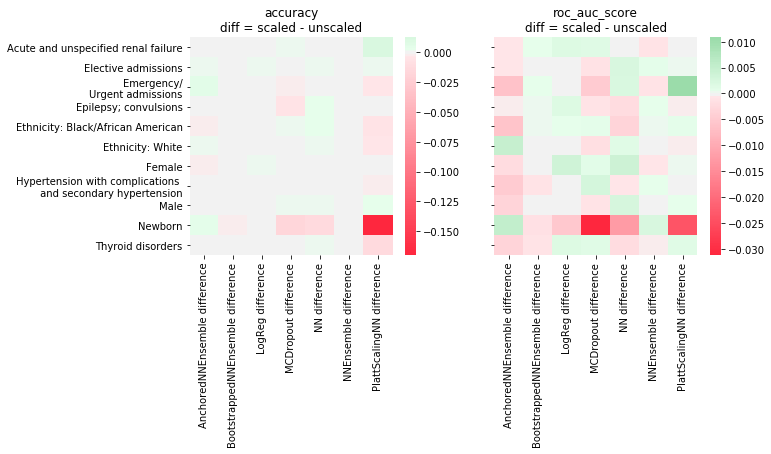

In [26]:
plot_difference_ood_metrics(metric_dict,metric_dict_unsc)

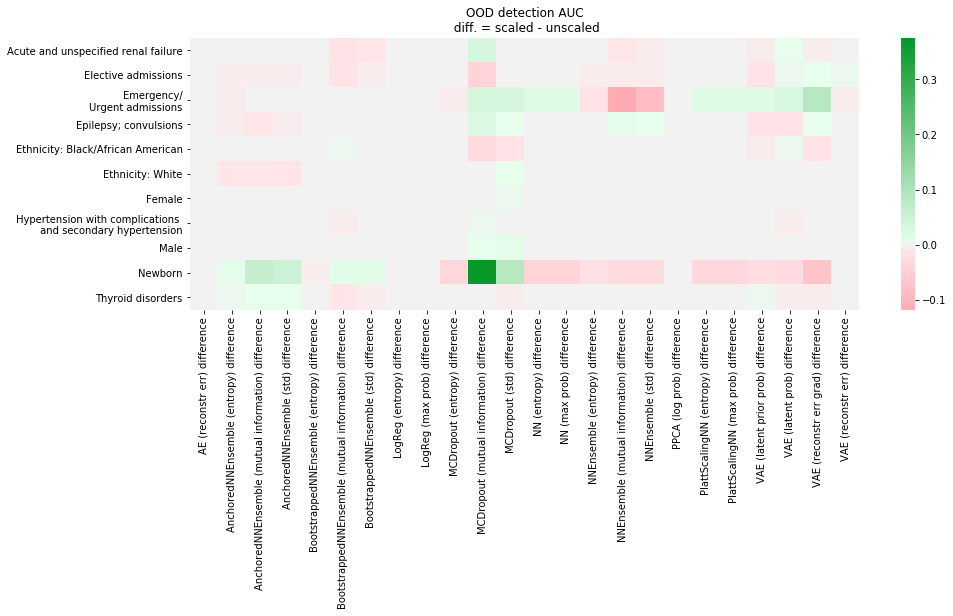

In [7]:
plot_difference_ood(auc_dict,auc_dict_unsc)

In [8]:
novelty_unscaled, metrics_unscaled = load_novelty_scores_from_origin(models = AVAILABLE_MODELS - {"PPCA"},
                                                       result_dir = RESULT_DIR,
                                                       data_origin = "MIMIC_unscaled")

novelty_scaled, metrics_scaled = load_novelty_scores_from_origin(models = AVAILABLE_MODELS - {"PPCA"},
                                                       result_dir = RESULT_DIR,
                                                       data_origin = "MIMIC")

In [15]:
def plot_difference_metrics(result_dict_scaled,
                            result_dict_unscaled,
                            title = "",
                            ttype = 'train'):
    
    plt.figure(figsize=(20,2))
    dfs = process_df(result_dict_scaled)
    dfu = process_df(result_dict_unscaled)

    cols = dfs.columns.intersection(dfu.columns)
    dfs, dfu = dfs[cols], dfu[cols]

    diff_df = pd.DataFrame()
    
    for col in dfs.columns:
            diff_df[f"{col} difference"]= dfs[col] - dfu[col]
            
    rdgn = sns.diverging_palette(h_neg=10, h_pos=130, s=99, l=55, sep=3, as_cmap=True)
    sns.heatmap(diff_df, cmap=rdgn, center=0.00, cbar=True, annot = True)
    
    plt.title(f"{title}\n diff. = scaled - unscaled")
    plt.show()

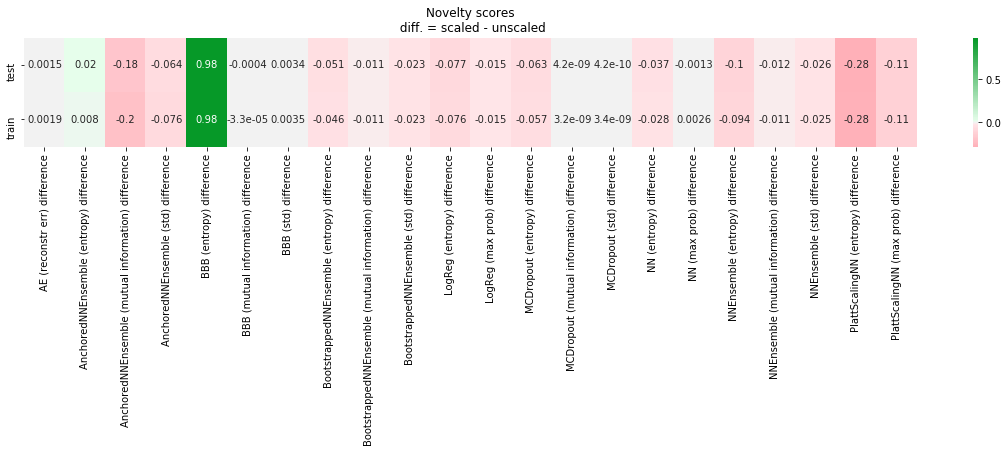

In [17]:
plot_difference_metrics(novelty_scaled, novelty_unscaled, title = "Novelty scores")

In [20]:
novelty_scaled

defaultdict(dict,
            {'LOF (outlier score)': defaultdict(list,
                         {'test': array([1.16678044, 1.24726279, 1.33964941, ..., 1.64696317, 1.4704822 ,
                                 1.30009408]),
                          'train': array([1.16900789, 1.18575407, 1.12435709, ..., 1.46301452, 1.09248308,
                                 1.06102497])}),
             'LogReg (entropy)': defaultdict(list,
                         {'test': array([0.57730771, 0.85127649, 0.37940176, ..., 0.02757405, 0.2159707 ,
                                 0.64395937]),
                          'train': array([0.04994052, 0.08633264, 0.57522531, ..., 0.85790351, 0.19881809,
                                 0.68232363])}),
             'LogReg (max prob)': defaultdict(list,
                         {'test': array([0.13736936, 0.27696077, 0.07365065, ..., 0.00277586, 0.03439414,
                                 0.1640706 ]),
                          'train': array([0.00559921, 

/home/karina/.conda/envs/vumcood/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice.
  after removing the cwd from sys.path.


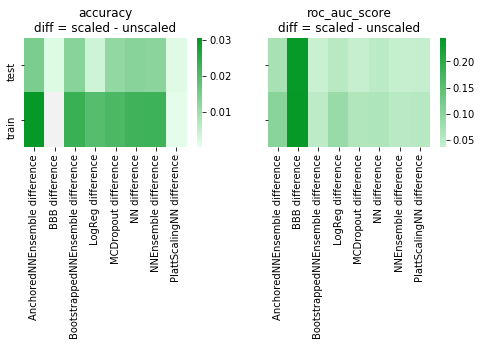

In [34]:
plot_difference_ood_metrics(metrics_scaled, metrics_unscaled, annot = False)

In [ ]:
novelty_unscaled, _ = load_novelty_scores_from_origin(models = AVAILABLE_MODELS - {"PPCA"},
                                                       result_dir = RESULT_DIR,
                                                       data_origin = "MIMIC_unscaled")

novelty_scaled, _ = load_novelty_scores_from_origin(models = AVAILABLE_MODELS - {"PPCA"},
                                                       result_dir = RESULT_DIR,
                                                       data_origin = "MIMIC")

In [ ]:
mean_train_s = np.mean(novelty_scaled['AE (reconstr err)']['test'])
mean_test_s = np.mean(novelty_scaled['AE (reconstr err)']['train'])

mean_train_u = np.mean(novelty_unscaled['AE (reconstr err)']['test'])
mean_test_u = np.mean(novelty_unscaled['AE (reconstr err)']['test'])

In [ ]:
print("AE")
print(f"Train data\n\t mean recontr. error \n\t scaled data = {mean_train_s}, unscaled data = {mean_train_u}")
print(f"Test data\n\t mean recontr. error \n\t scaled data = {mean_test_s}, unscaled data = {mean_test_u}")